<h1 style="text-align:center;">Data Science & Society Thesis</h1>
<h3 style="text-align:center;">FORECASTING CRYPTO PRICE  PEAKS: REGRESSION – BASED </h3>
<h3 style="text-align:center;">TIME – UNTIL – NEW - HIGH </h3>
<h3 style="text-align:center;">PREDICTIONS</h3>
<h5 style="text-align:center;"> ELEFTHERIOS DIAMANTIDIS</h5>

---

<h1 style="text-align:center;"> Exploratory Data Analysis </h1>

### **Step 1:** Import Libraries

In [1]:
# Import Basic Libraries
# type: ignore
import pandas as pd
import numpy as np
import matplotlib.pylab as plt                                                              
import seaborn as sns                                                                        
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)        # Prevent line-wrapping

import plotly.express as px

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

### **Step 2:** Import data

In [2]:
coins = ['btc', 'eth', 'bnb', 'aave', 'sol', 'ltc', 'xrp', 'ada', 'doge', 'paxg']

for coin in coins:
    path = Path("data") / f"final_data_{coin}.csv"
    df = pd.read_csv(path)
    # add uppercase coin column
    df['coin'] = coin.upper()
    # normalize and set date
    df = df.rename(columns={"Date": "date"})
    df['date'] = pd.to_datetime(df['date'])
    # extract just the date (no time)
    df['Date'] = df['date'].dt.date
    df['date'] = df['date'].dt.date
    df = df.set_index('date').sort_index()
    # assign to variable named df_<coin>
    globals()[f"df_{coin}"] = df


In [3]:
print(df_btc.head())

              Open    High     Low   Close  Volume  tunh coin        Date
date                                                                     
2010-07-17  0.0500  0.0500  0.0500  0.0500     0.0   1.0  BTC  2010-07-17
2010-07-18  0.0858  0.0858  0.0858  0.0858     0.0  82.0  BTC  2010-07-18
2010-07-19  0.0808  0.0808  0.0808  0.0808     0.0  81.0  BTC  2010-07-19
2010-07-20  0.0747  0.0747  0.0747  0.0747     0.0   1.0  BTC  2010-07-20
2010-07-21  0.0792  0.0792  0.0792  0.0792     0.0  79.0  BTC  2010-07-21


In [4]:
print(df_doge.head())

                Open      High       Low     Close   Volume  tunh  coin        Date
date                                                                               
2017-11-09  0.001207  0.001415  0.001181  0.001415  6259550   1.0  DOGE  2017-11-09
2017-11-10  0.001421  0.001431  0.001125  0.001163  4246520  11.0  DOGE  2017-11-10
2017-11-11  0.001146  0.001257  0.001141  0.001201  2231080   4.0  DOGE  2017-11-11
2017-11-12  0.001189  0.001210  0.001002  0.001038  3288960   1.0  DOGE  2017-11-12
2017-11-13  0.001046  0.001212  0.001019  0.001211  2481270   1.0  DOGE  2017-11-13


### **Step 3:** Handle missing data & outliers

In [5]:
for coin in coins:
    df = globals()[f"df_{coin}"]
    # 1) forward/back‐fill missing TUNH and compute 99th‐percentile threshold
    df['tunh'] = df['tunh'].ffill().bfill()
    upper_limit = df['tunh'].quantile(0.99)
    # 2) flag and remove outliers
    df['tunh_outlier'] = df['tunh'] > upper_limit
    num_outliers = df['tunh_outlier'].sum()
    pct = 100 * num_outliers / len(df)
    print(f"{coin.upper()}: Detected {num_outliers} outliers ({pct:.2f}%) above {upper_limit:.2f} days.")
    df = df[~df['tunh_outlier']].copy()
    print(f"{coin.upper()}: final shape {df.shape}\n")
    # 3) clean up
    df.drop(columns=['tunh_outlier'], inplace=True)
    # 4) write back to the global name
    globals()[f"df_{coin}"] = df

BTC: Detected 54 outliers (1.00%) above 710.20 days.
BTC: final shape (5327, 9)

ETH: Detected 28 outliers (1.03%) above 949.12 days.
ETH: final shape (2681, 9)

BNB: Detected 28 outliers (1.03%) above 685.36 days.
BNB: final shape (2681, 9)

AAVE: Detected 17 outliers (1.03%) above 929.50 days.
AAVE: final shape (1634, 9)

SOL: Detected 19 outliers (1.04%) above 788.00 days.
SOL: final shape (1807, 9)

LTC: Detected 39 outliers (1.01%) above 556.86 days.
LTC: final shape (3819, 9)

XRP: Detected 28 outliers (1.03%) above 1127.92 days.
XRP: final shape (2681, 9)

ADA: Detected 28 outliers (1.03%) above 980.60 days.
ADA: final shape (2681, 9)

DOGE: Detected 28 outliers (1.03%) above 1080.92 days.
DOGE: final shape (2681, 9)

PAXG: Detected 21 outliers (1.04%) above 243.86 days.
PAXG: final shape (2002, 9)



### **Step 4:** Log-transform target

In [6]:
for coin in coins:
    df = globals()[f"df_{coin}"]
    df['tunh_log'] = np.log1p(df['tunh'])
    globals()[f"df_{coin}"] = df

In [7]:
print(df_btc.head())

              Open    High     Low   Close  Volume  tunh coin        Date  tunh_log
date                                                                               
2010-07-17  0.0500  0.0500  0.0500  0.0500     0.0   1.0  BTC  2010-07-17  0.693147
2010-07-18  0.0858  0.0858  0.0858  0.0858     0.0  82.0  BTC  2010-07-18  4.418841
2010-07-19  0.0808  0.0808  0.0808  0.0808     0.0  81.0  BTC  2010-07-19  4.406719
2010-07-20  0.0747  0.0747  0.0747  0.0747     0.0   1.0  BTC  2010-07-20  0.693147
2010-07-21  0.0792  0.0792  0.0792  0.0792     0.0  79.0  BTC  2010-07-21  4.382027


### **Step 5:** Plots

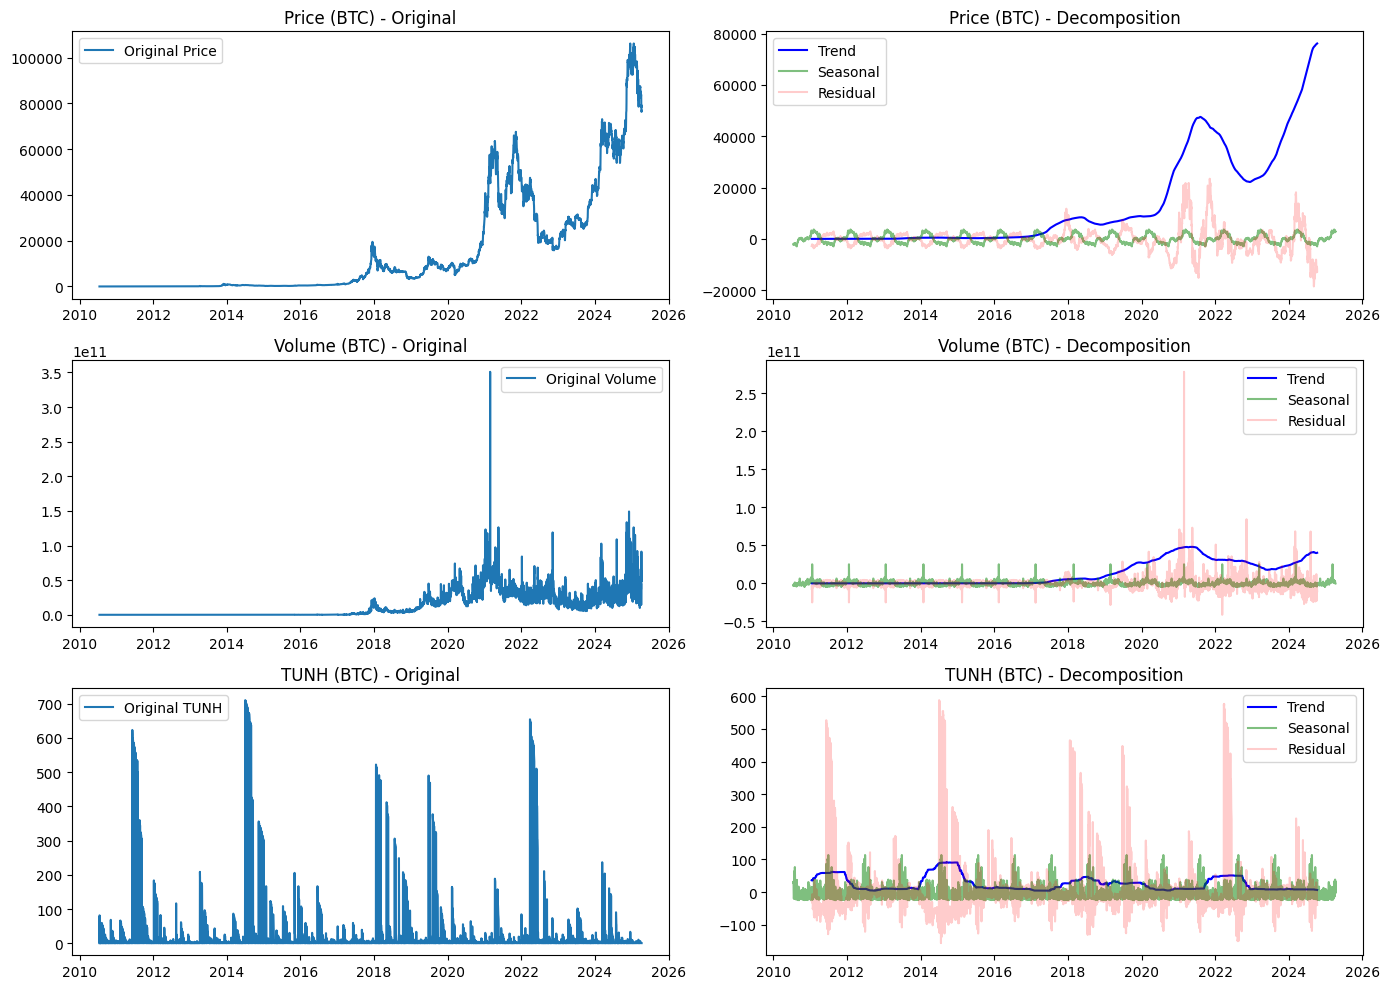

In [8]:
# Decompose the time series for 'Close', 'Volume', and 'tunh'
decomposition_price = sm.tsa.seasonal_decompose(df_btc['Close'], model='additive', period=365)
decomposition_volume = sm.tsa.seasonal_decompose(df_btc['Volume'], model='additive', period=365)
decomposition_tunh = sm.tsa.seasonal_decompose(df_btc['tunh'], model='additive', period=365)

# Create the subplots for Price, Volume, and TUNH
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# Price (Close)
axes[0, 0].plot(df_btc['Close'], label='Original Price')
axes[0, 0].set_title('Price (BTC) - Original')
axes[0, 0].legend()

axes[0, 1].plot(decomposition_price.trend, label='Trend', color='blue')
axes[0, 1].plot(decomposition_price.seasonal, label='Seasonal', color='green', alpha=0.5)
axes[0, 1].plot(decomposition_price.resid, label='Residual', color='red', alpha=0.2)
axes[0, 1].set_title('Price (BTC) - Decomposition')
axes[0, 1].legend()

# Volume
axes[1, 0].plot(df_btc['Volume'], label='Original Volume')
axes[1, 0].set_title('Volume (BTC) - Original')
axes[1, 0].legend()

axes[1, 1].plot(decomposition_volume.trend, label='Trend', color='blue')
axes[1, 1].plot(decomposition_volume.seasonal, label='Seasonal', color='green', alpha=0.5)
axes[1, 1].plot(decomposition_volume.resid, label='Residual', color='red', alpha=0.2)
axes[1, 1].set_title('Volume (BTC) - Decomposition')
axes[1, 1].legend()

# TUNH
axes[2, 0].plot(df_btc['tunh'], label='Original TUNH')
axes[2, 0].set_title('TUNH (BTC) - Original')
axes[2, 0].legend()

axes[2, 1].plot(decomposition_tunh.trend, label='Trend', color='blue')
axes[2, 1].plot(decomposition_tunh.seasonal, label='Seasonal', color='green', alpha=0.5)
axes[2, 1].plot(decomposition_tunh.resid, label='Residual', color='red', alpha=0.2)
axes[2, 1].set_title('TUNH (BTC) - Decomposition')
axes[2, 1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [10]:
print(df_btc.head())

              Open    High     Low   Close  Volume  tunh coin        Date  tunh_log
date                                                                               
2010-07-17  0.0500  0.0500  0.0500  0.0500     0.0   1.0  BTC  2010-07-17  0.693147
2010-07-18  0.0858  0.0858  0.0858  0.0858     0.0  82.0  BTC  2010-07-18  4.418841
2010-07-19  0.0808  0.0808  0.0808  0.0808     0.0  81.0  BTC  2010-07-19  4.406719
2010-07-20  0.0747  0.0747  0.0747  0.0747     0.0   1.0  BTC  2010-07-20  0.693147
2010-07-21  0.0792  0.0792  0.0792  0.0792     0.0  79.0  BTC  2010-07-21  4.382027


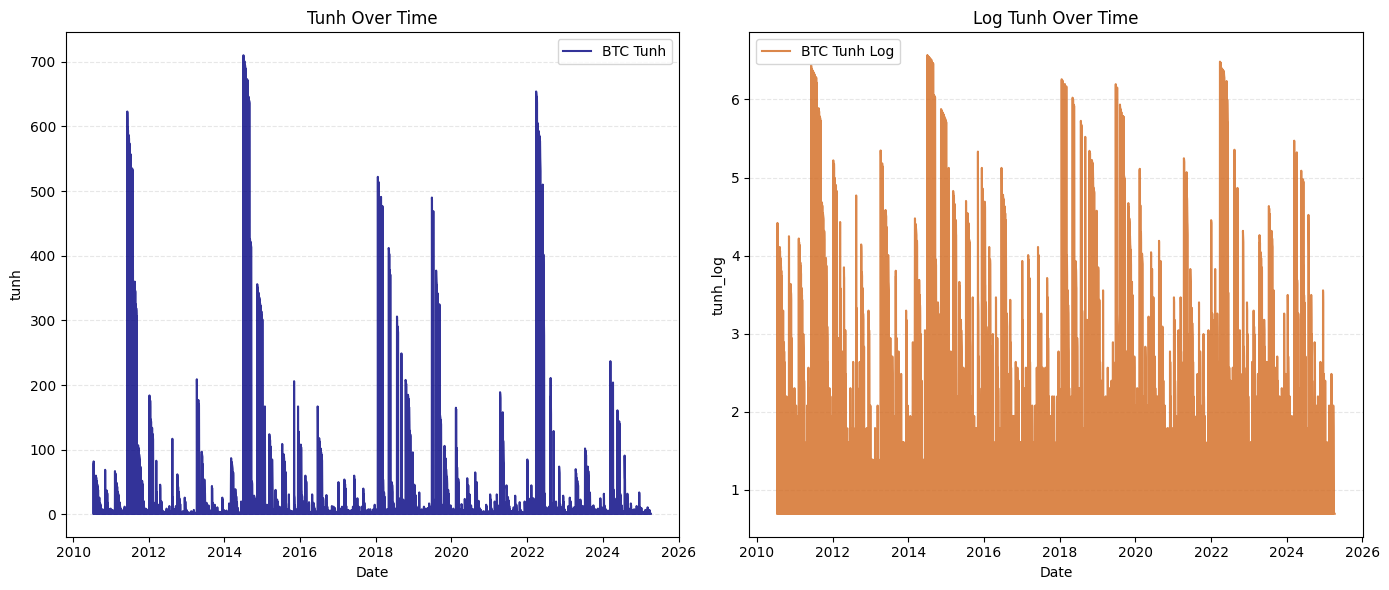

In [11]:
# Create the figure and axes for subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First plot: Tunh Over Time
sns.lineplot(x=df_btc["Date"], y=df_btc["tunh"], color="navy", alpha=0.8, label="BTC Tunh", ax=axes[0])
axes[0].set_title("Tunh Over Time")
axes[0].set_xlabel('Date')
axes[0].set_ylabel('tunh')
axes[0].legend()
axes[0].grid(visible=True, alpha=0.3, linestyle='--', axis='y')
axes[0].grid(visible=False, alpha=0.0, axis='x')

# Second plot: Log Tunh Over Time
sns.lineplot(x=df_btc["Date"], y=df_btc["tunh_log"], color="chocolate", alpha=0.8, label="BTC Tunh Log", ax=axes[1])
axes[1].set_title("Log Tunh Over Time")
axes[1].set_xlabel('Date')
axes[1].set_ylabel('tunh_log')
axes[1].legend()
axes[1].grid(visible=True, alpha=0.3, linestyle='--', axis='y')
axes[1].grid(visible=False, alpha=0.0, axis='x')

plt.tight_layout()
plt.show()

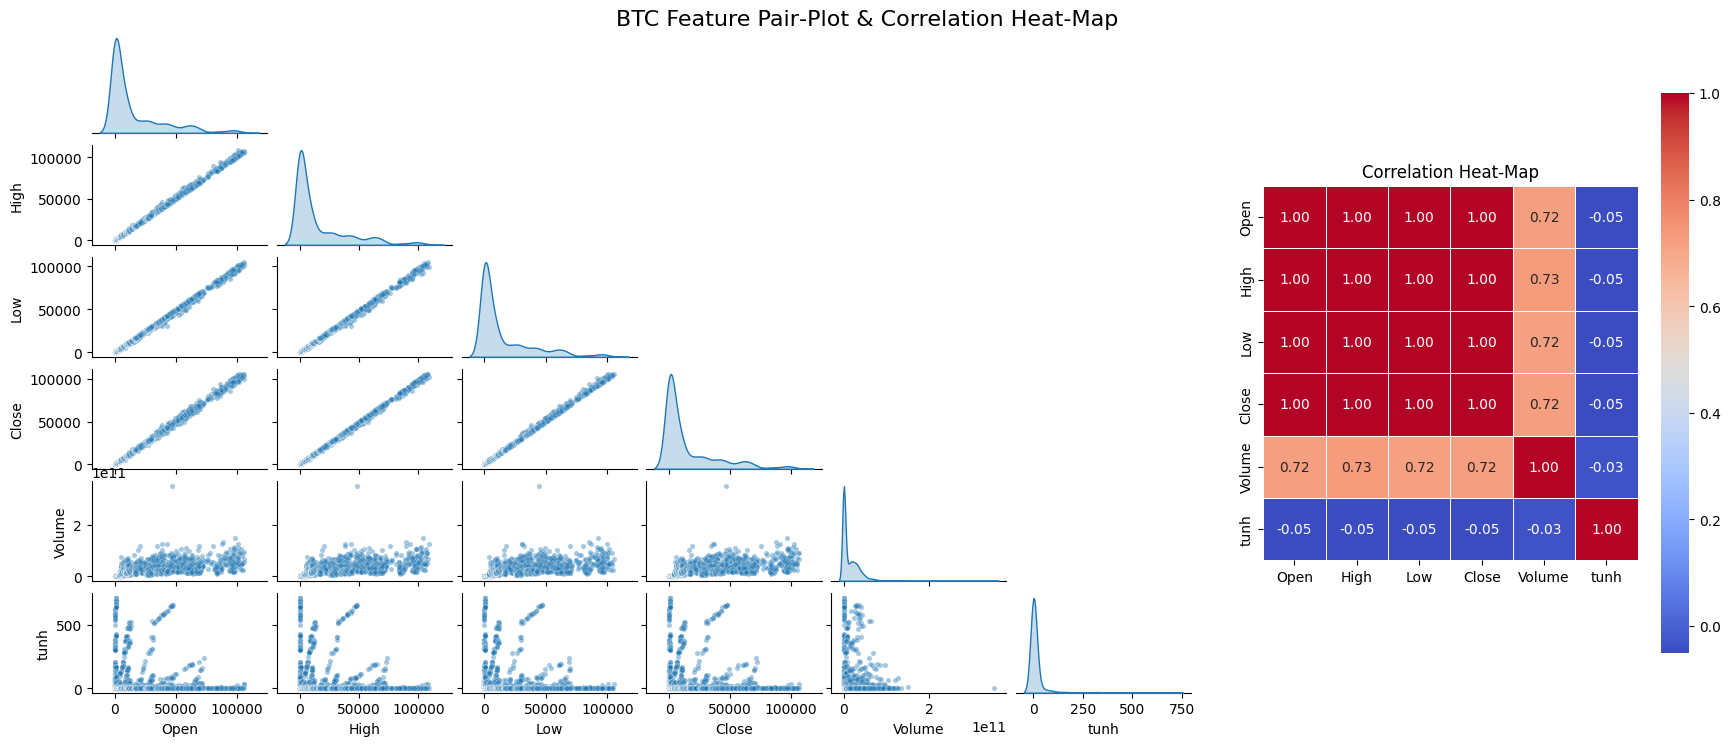

In [16]:
num_cols = ["Open", "High", "Low", "Close", "Volume", "tunh"]

g = sns.pairplot(
    df_btc[num_cols],
    diag_kind="kde",
    corner=True,
    plot_kws={"alpha": 0.4, "s": 14}
)
g.fig.set_size_inches(18, 7)          # make it wide enough

g.fig.subplots_adjust(right=0.68)     # 68 % of width → pair‑plot; rest → heat‑map

ax_heat = g.fig.add_axes([0.72, 0.10, 0.26, 0.80])   # [left, bottom, width, height]

corr = df_btc[num_cols].corr(method="pearson")
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    square=True,
    ax=ax_heat
)
ax_heat.set_title("Correlation Heat‑Map", fontsize=12)

g.fig.suptitle("BTC Feature Pair‑Plot & Correlation Heat‑Map", y=1.02, fontsize=16)
plt.show()

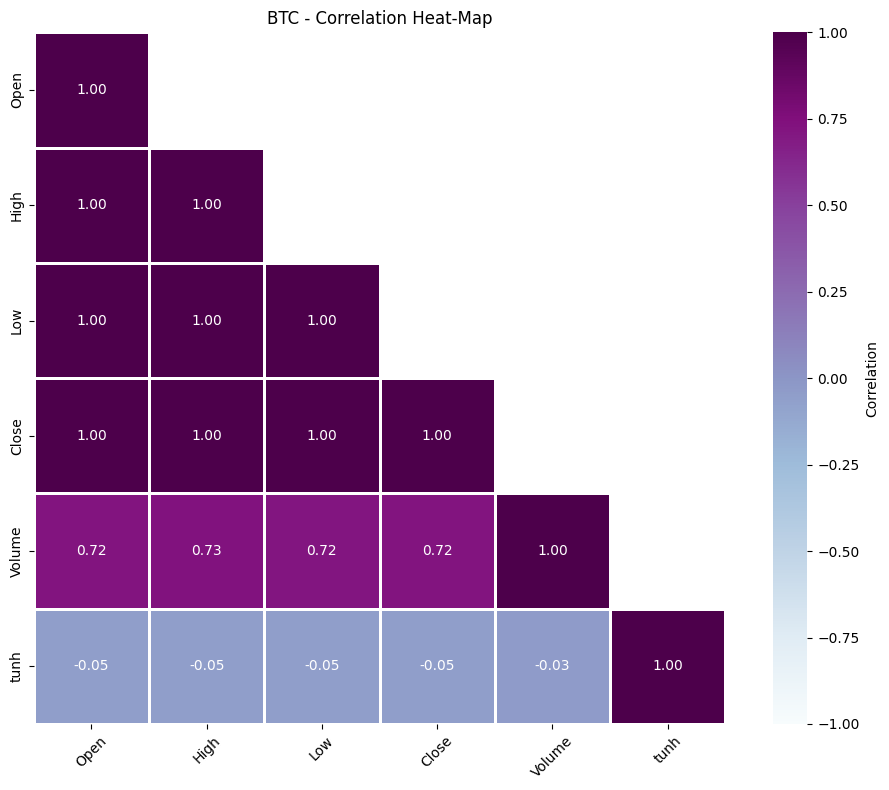

In [92]:
columns = ["Open", "High", "Low", "Close", "Volume", "tunh"]
corr = df_btc[columns].corr(method="pearson")
plt.figure(figsize=(10, 8))
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Features", fontsize=12)

sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="BuPu",
    cbar=True,
    cbar_kws={"shrink": 1, "location":"right", "label": "Correlation", "orientation": "vertical", "pad": 0.05, "aspect": 20},
    mask=np.triu(corr, k=1),
    annot_kws={"size": 10},
    xticklabels=corr.columns,
    yticklabels=corr.columns,
    linewidths=1,
    linecolor="white",
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
)
plt.title("BTC - Correlation Heat-Map", fontsize=12)
plt.savefig("Plots/10. eda/btc_correlation_heatmap.png", dpi=300)
plt.tight_layout()
plt.show()

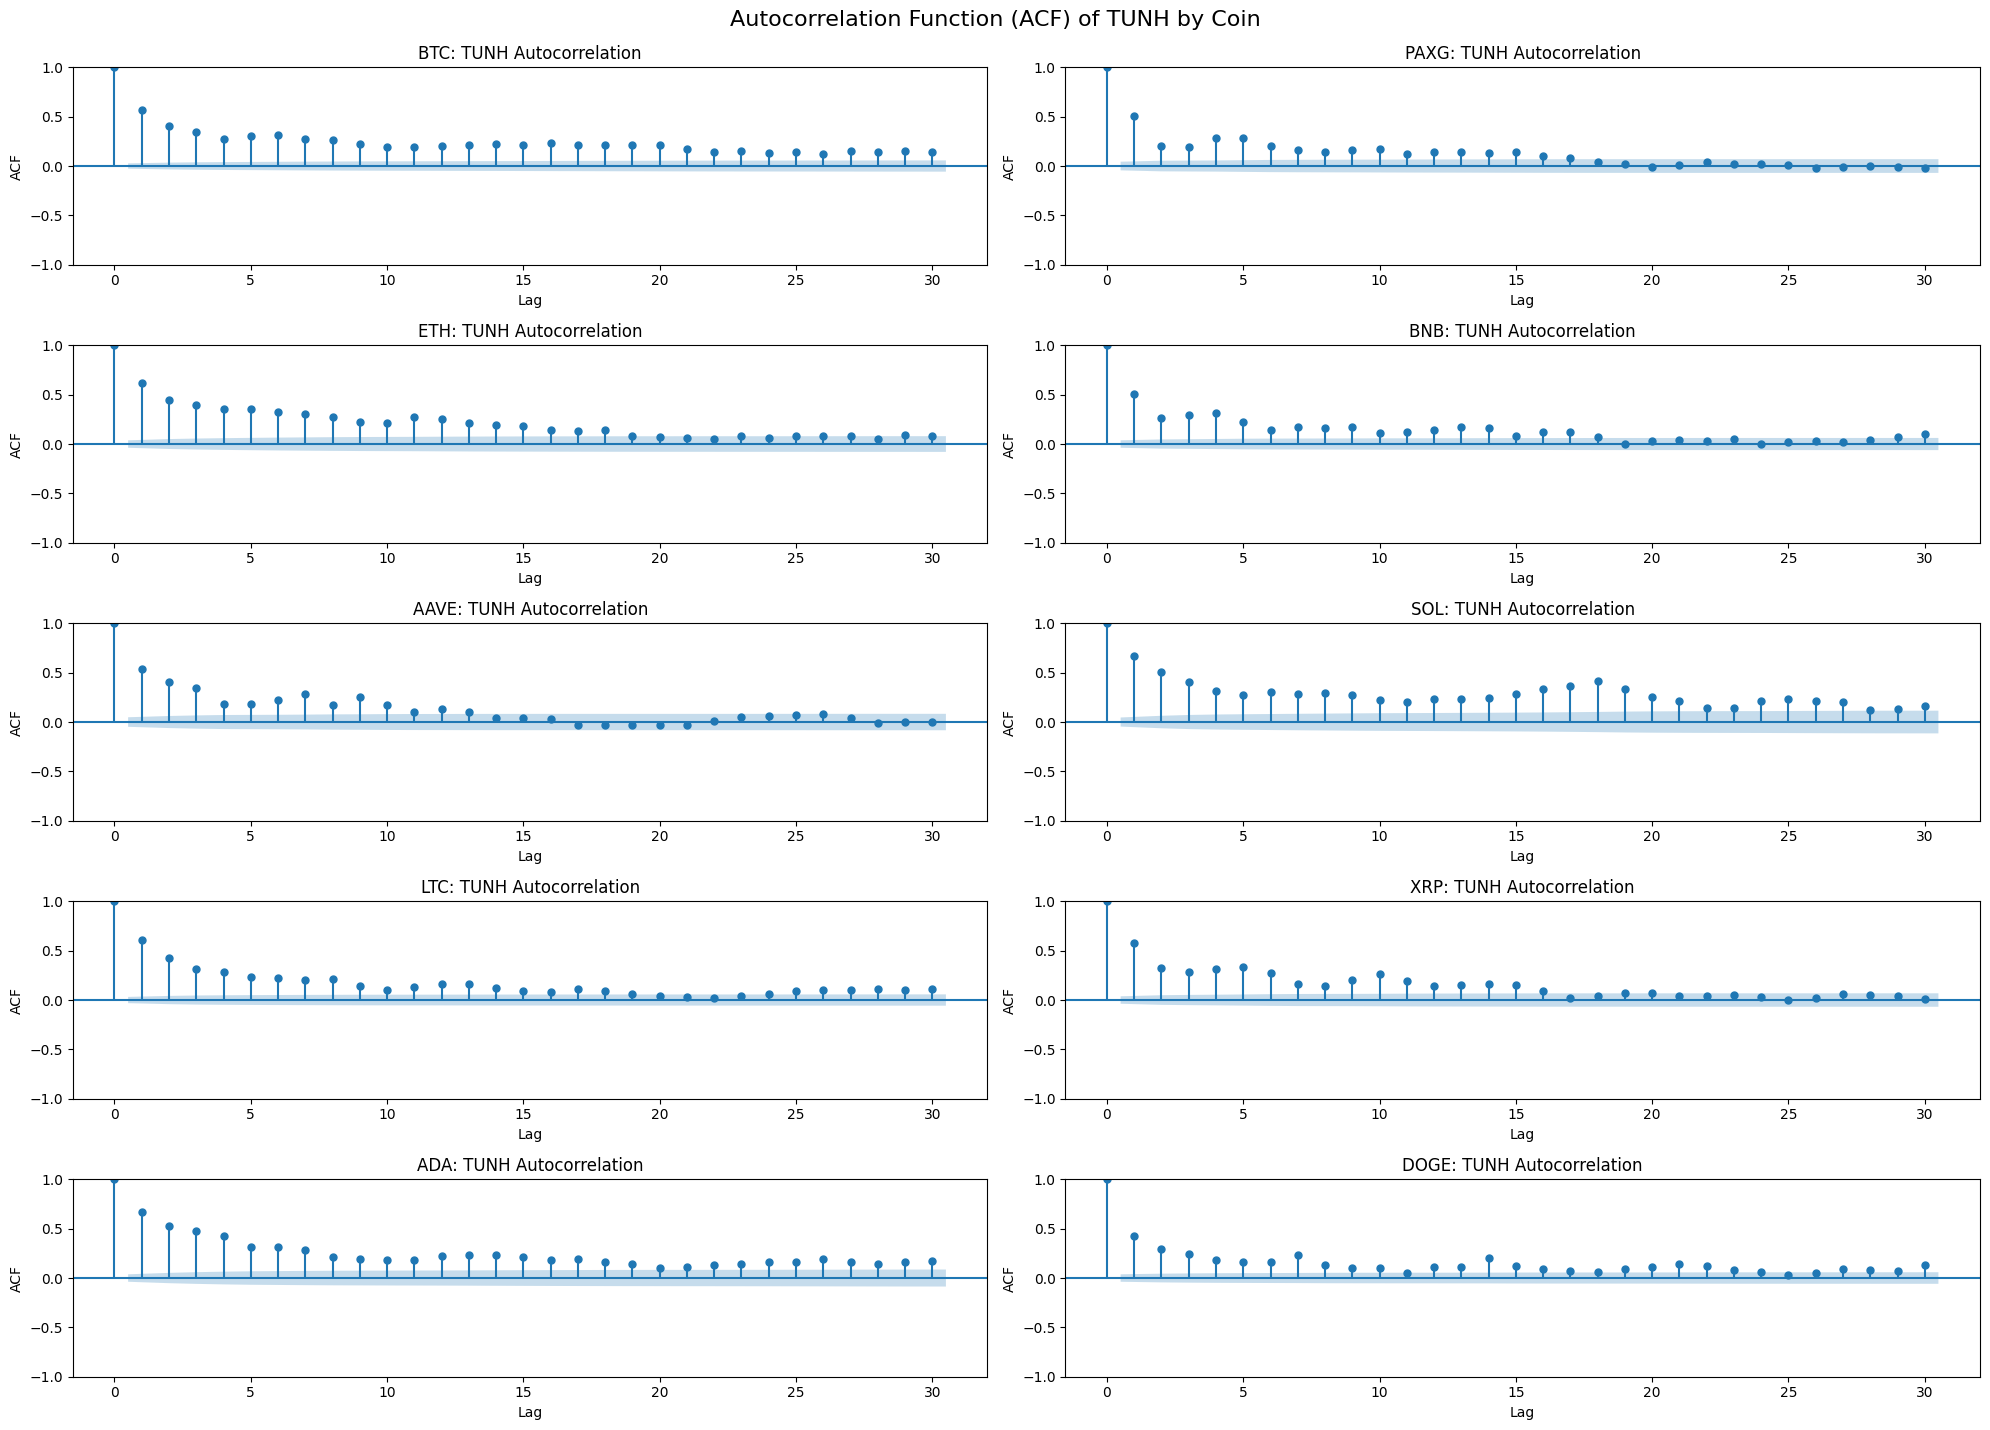

In [14]:
# ─── 1) ACF plot for TUNH per coin ─────────────────────────────────────────────

coins = {'BTC': df_btc, 'PAXG': df_paxg, 'ETH': df_eth, 'BNB': df_bnb,
        'AAVE': df_aave, 'SOL': df_sol, 'LTC': df_ltc, 'XRP': df_xrp,
        'ADA': df_ada, 'DOGE': df_doge}

fig, axes = plt.subplots(5, 2, figsize=(20, 15))
axes = axes.flatten()

for ax, (name, df) in zip(axes, coins.items()):
    plot_acf(df['tunh'].dropna(), lags=30, alpha=0.05, ax=ax)
    ax.set_title(f'{name}: TUNH Autocorrelation')
    ax.set_xlabel('Lag')
    ax.set_ylabel('ACF')

fig.suptitle('Autocorrelation Function (ACF) of TUNH by Coin', fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

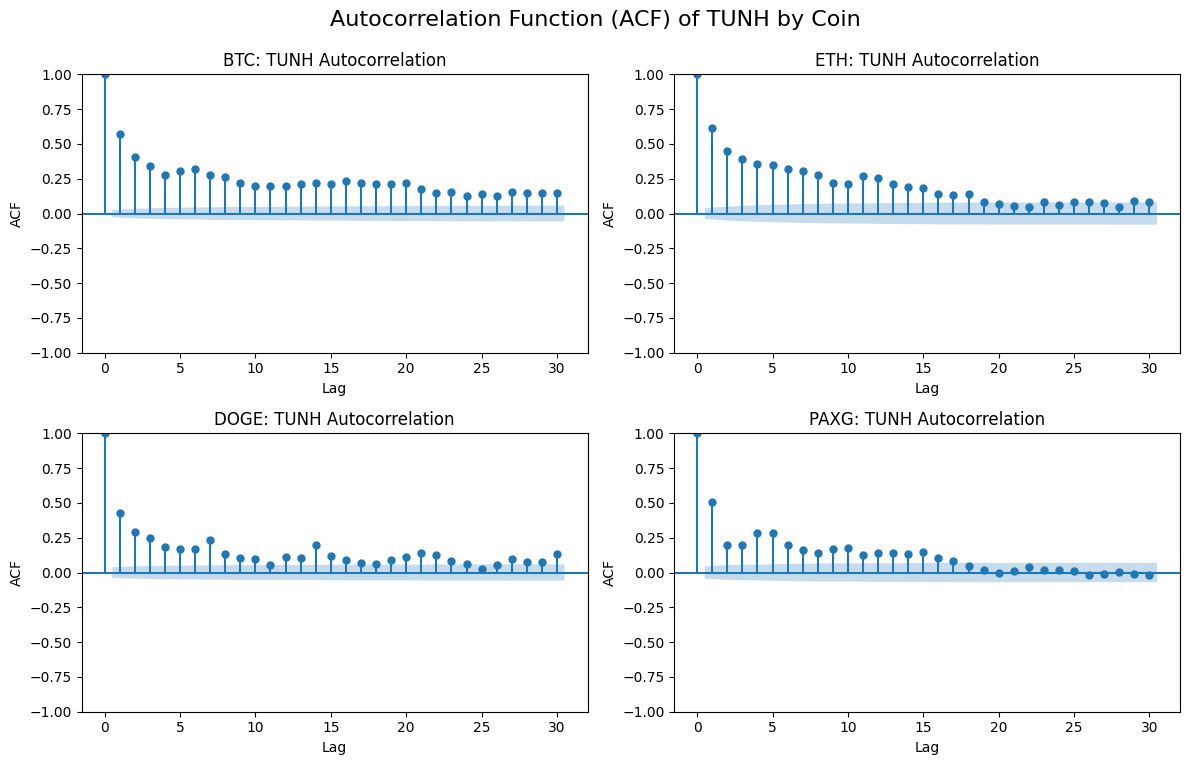

In [15]:
coins = {'BTC': df_btc, 'ETH': df_eth, 'DOGE': df_doge, 'PAXG': df_paxg}
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, (name, df) in zip(axes, coins.items()):
    plot_acf(df['tunh'].dropna(), lags=30, alpha=0.05, ax=ax)
    ax.set_title(f'{name}: TUNH Autocorrelation')
    ax.set_xlabel('Lag')
    ax.set_ylabel('ACF')

fig.suptitle('Autocorrelation Function (ACF) of TUNH by Coin', fontsize=16, y=0.95)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('Plots/10. eda/acf_tunh.png', dpi=300, bbox_inches='tight')
plt.show()

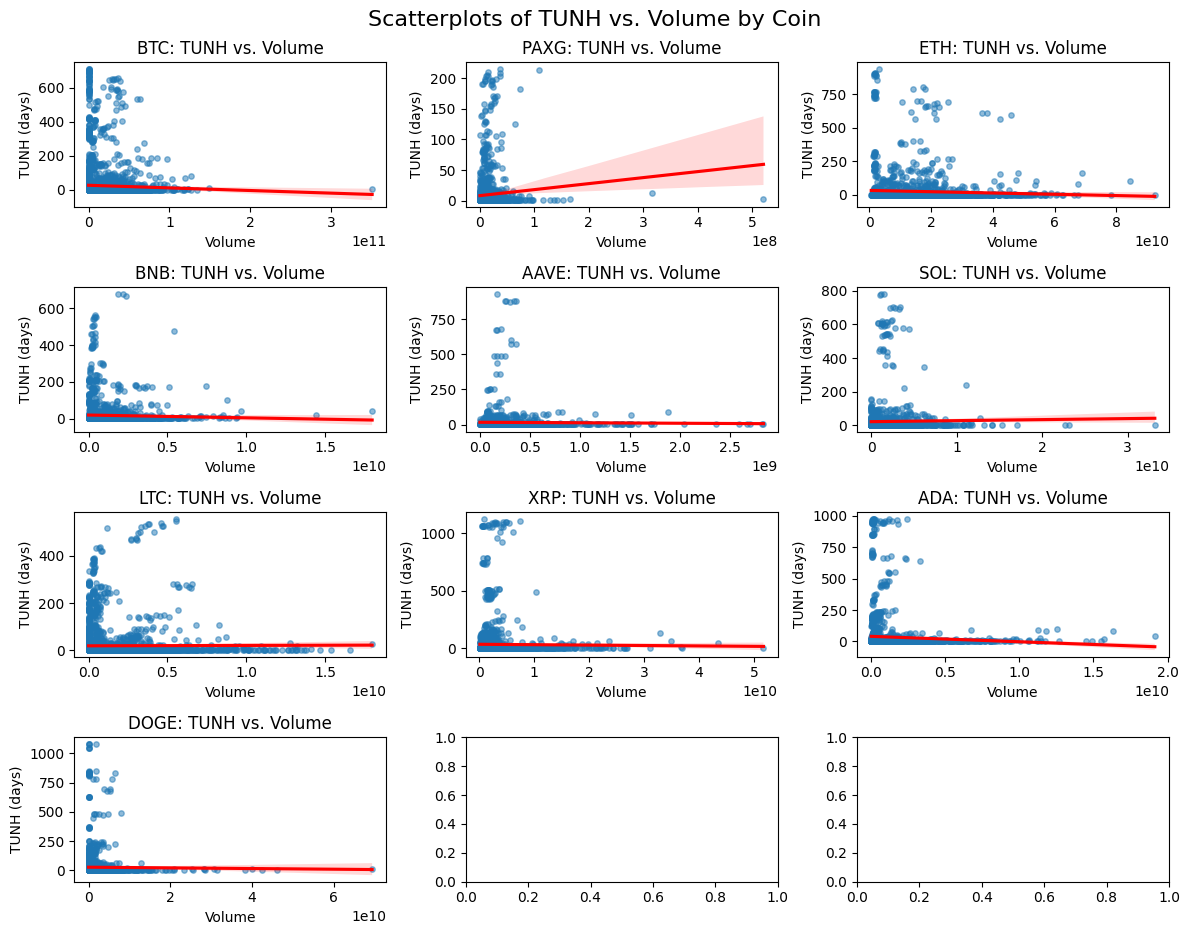

In [16]:
# ─── 2) Scatterplot of TUNH vs Volume per coin ────────────────────────────────
coins = {'BTC': df_btc, 'PAXG': df_paxg, 'ETH': df_eth, 'BNB': df_bnb,
        'AAVE': df_aave, 'SOL': df_sol, 'LTC': df_ltc, 'XRP': df_xrp,
        'ADA': df_ada, 'DOGE': df_doge}

fig, axes = plt.subplots(4, 3, figsize=(12, 10))
axes = axes.flatten()

for ax, (name, df) in zip(axes, coins.items()):
    sns.regplot(
        x='Volume', y='tunh',
        data=df.dropna(subset=['Volume','tunh']),
        scatter_kws={'s': 15, 'alpha':0.5},
        line_kws={'color':'red'},
        ax=ax
    )
    ax.set_title(f'{name}: TUNH vs. Volume')
    ax.set_xlabel('Volume')
    ax.set_ylabel('TUNH (days)')

fig.suptitle('Scatterplots of TUNH vs. Volume by Coin', fontsize=16, y=0.93)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

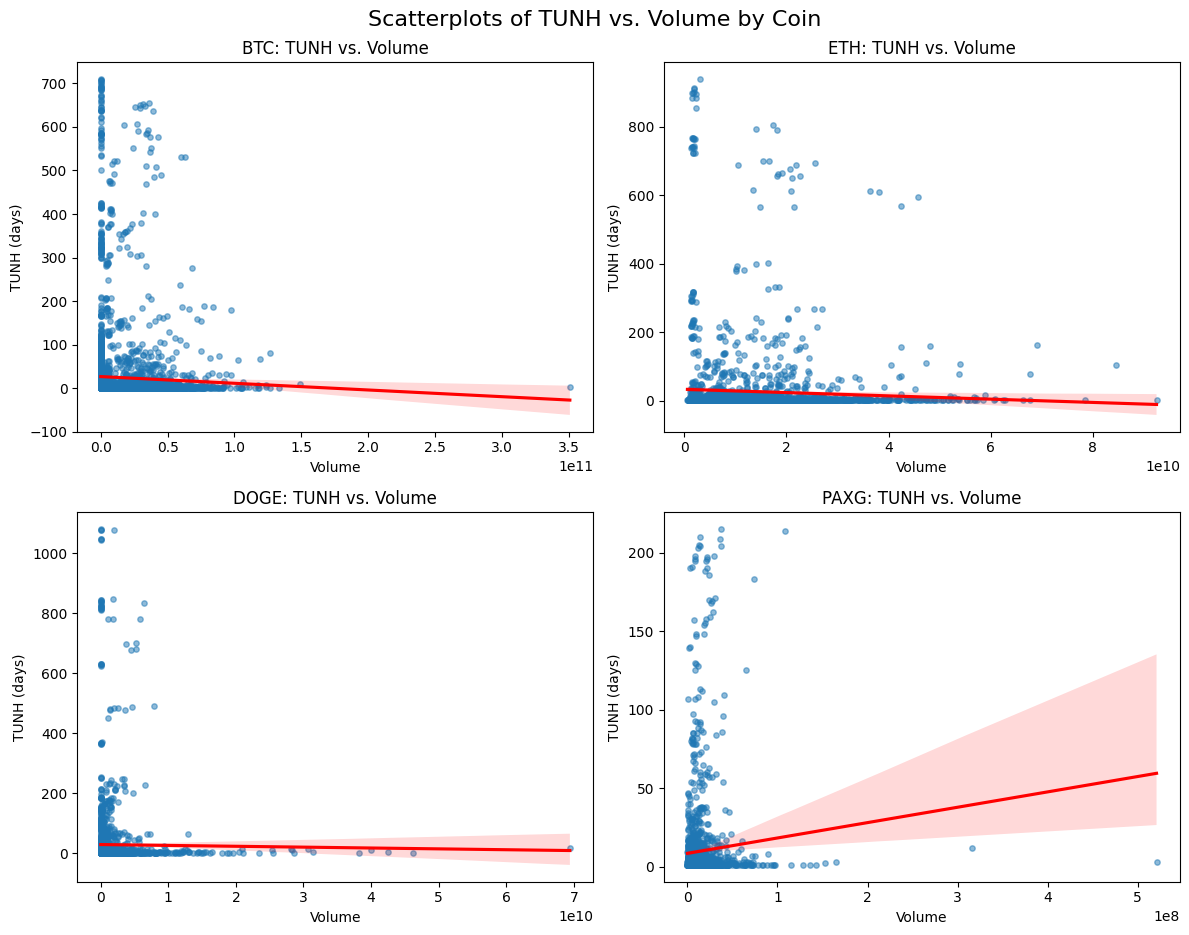

In [17]:
# ─── 2) Scatterplot of TUNH vs Volume per coin ────────────────────────────────
coins = {'BTC': df_btc, 'ETH': df_eth, 'DOGE': df_doge, 'PAXG': df_paxg}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (name, df) in zip(axes, coins.items()):
    sns.regplot(
        x='Volume', y='tunh',
        data=df.dropna(subset=['Volume','tunh']),
        scatter_kws={'s': 15, 'alpha':0.5},
        line_kws={'color':'red'},
        ax=ax
    )
    ax.set_title(f'{name}: TUNH vs. Volume')
    ax.set_xlabel('Volume')
    ax.set_ylabel('TUNH (days)')

fig.suptitle('Scatterplots of TUNH vs. Volume by Coin', fontsize=16, y=0.93)
plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig('Plots/10. eda/scatter_tunh_volume.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# ─── 3) Boxplots comparing TUNH across coins ──────────────────────────────────
coins = {'BTC': df_btc, 'PAXG': df_paxg, 'ETH': df_eth, 'BNB': df_bnb,
        'AAVE': df_aave, 'SOL': df_sol, 'LTC': df_ltc, 'XRP': df_xrp,
        'ADA': df_ada, 'DOGE': df_doge}

# concatenate all coins into one DF
df_list = []
for name, df in coins.items():
    temp = df[['tunh']].copy()
    temp['coin'] = name
    df_list.append(temp)
df_all = pd.concat(df_list)

In [14]:
# Calculate statistics per coin
stats_per_coin = df_all.groupby('coin')['tunh'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()
stats_per_coin.rename(columns={'mean': 'Mean', 'median': 'Median', 'std': 'Std Dev', 'min': 'Min', 'max': 'Max'}, inplace=True)

# Create an interactive boxplot
fig = px.box(df_all, x='coin', y='tunh', color='coin')
fig.update_layout(
    title = dict(
        text='TUNH Distribution by Coin',
        x=0.5,  # Center the title
        y=0.95,  # Add space from the plot
        xanchor='center',
        yanchor='top'
    ),
    yaxis_title='TUNH (days)',
    xaxis_title='Coin',
    yaxis=dict(range=[0, 30]),  # Set initial zoom range for y-axis
    margin=dict(t=130),  # Add extra space at the top
    showlegend=False,
    height=800,
    width=1200
)

# Add statistics as annotations
for i, row in stats_per_coin.iterrows():
    fig.add_annotation(
        x=row['coin'],
        y=30,  # Position above the boxplot
        text=f"Mean: {row['Mean']:.2f}<br>Median: {row['Median']:.2f}<br>Std Dev: {row['Std Dev']:.2f}<br>Max: {row['Max']:.2f}<br>Min: {row['Min']:.2f}",
        font=dict(size=10),
        align="center",
        bgcolor="rgba(255, 255, 255, 0.7)",
        bordercolor="black",
        borderwidth=1
    )

fig.write_image("Plots/10. eda/boxplot_tunh.png")
fig.show()

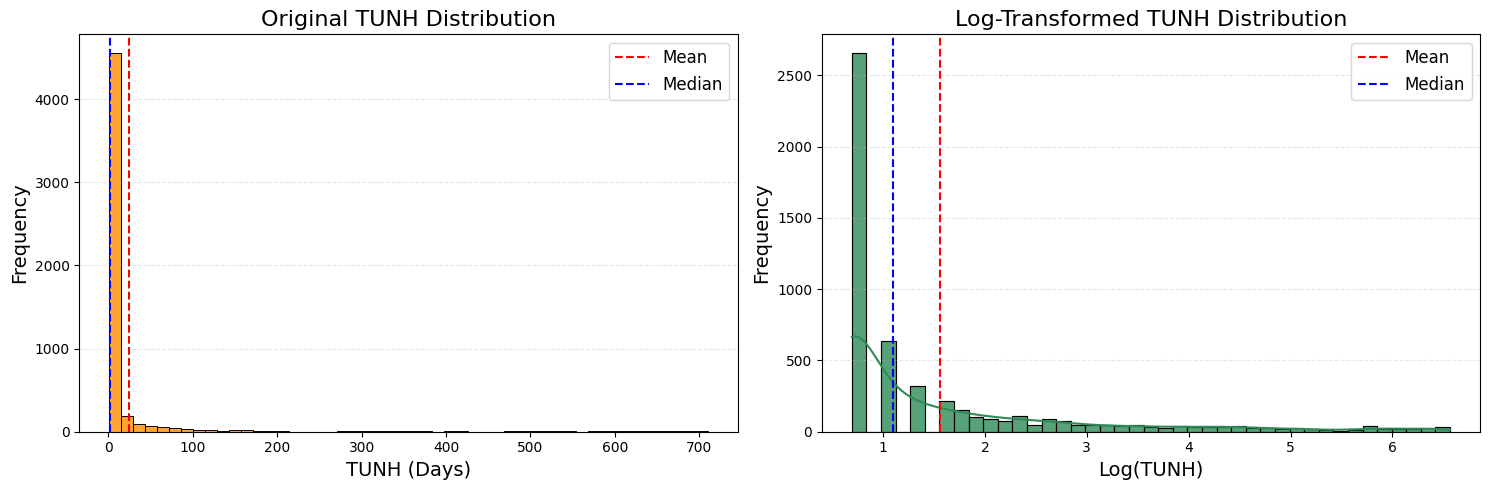

In [135]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_btc['tunh'], bins=50, color='darkorange', edgecolor="black", alpha=0.8)
plt.title('Original TUNH Distribution', fontsize=16, color='black')
plt.xlabel('TUNH (Days)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(visible=True, alpha=0.3, linestyle='--', axis='y')
plt.axvline(df_btc['tunh'].mean(), color='red', linestyle='--', linewidth=1.5, label='Mean')
plt.axvline(df_btc['tunh'].median(), color='blue', linestyle='--', linewidth=1.5, label='Median')
plt.legend(fontsize=12)

# Plot transformed TUNH (log-transformed) histogram
plt.subplot(1, 2, 2)
sns.histplot(df_btc['tunh_log'], kde=True, color='seagreen', edgecolor="black", alpha=0.8)
plt.title('Log-Transformed TUNH Distribution', fontsize=16, color='black')
plt.xlabel('Log(TUNH)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(visible=True, alpha=0.3, linestyle='--', axis='y')
plt.axvline(df_btc['tunh_log'].mean(), color='red', linestyle='--', linewidth=1.5, label='Mean')
plt.axvline(df_btc['tunh_log'].median(), color='blue', linestyle='--', linewidth=1.5, label='Median')
plt.legend(fontsize=12)

# Adjust layout and show the plots
plt.savefig('Plots/10. eda/histogram_btc.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()